# Calculate beam intensity and resolution vs FC freq

    fluxmode:
      High Flux (HF)    = 9.0 deg
      Intermidiste (AI) = 4.4 deg
      High Res (HR)     = 2.0 deg
    Frequency DoubleDisk Chopper 1: (Hz)         300 Hz for HF       240 Hz for AI        180 Hz for HR
    Frequency DoubleDisk Chopper 2: (Hz)         300 Hz for HF       240 Hz for AI        180 Hz for HR


In [78]:
import os, sys, numpy as np
import histogram.hdf as hh, histogram as H
import mcvine, mcvine.components, mcvine.run_script
from mcni.utils import conversion as C

from matplotlib import pyplot as plt
%matplotlib notebook

In [88]:
workdir = os.path.expanduser("/SNS/users/lj7/dv/sns-chops/resolution/CNCS/mcvine/Ei_1meV")
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/dv/sns-chops/resolution/CNCS/mcvine/Ei_1meV


In [3]:
sys.path.insert(0, os.path.abspath('../../PyChop/'))

In [4]:
import Vdata2018
reload(Vdata2018)

<module 'Vdata2018' from '/SNS/users/lj7/dv/sns-chops/resolution/CNCS/PyChop/Vdata2018.pyc'>

In [5]:
expdata_highres = Vdata2018.ExpData(os.path.join(Vdata2018.datadir, './V_Cali_Int_Res_HighRes.dat'))

reading data. please wait...
  done


In [16]:
# expdata_highres.vdata

# Sample

Hieght=63mm

In [69]:
%%file ./sampleassembly.xml
<SampleAssembly name="bcc V powder sample assembly">

  <PowderSample name="V" type="sample">
    <Shape>
      <hollowCylinder in_radius="5*mm" out_radius="6*mm" height="63*mm"  />
    </Shape>
    <Phase type="crystal">
      <ChemicalFormula>V</ChemicalFormula>
      <xyzfile>V.xyz</xyzfile>
    </Phase>
  </PowderSample>

  <LocalGeometer registry-coordinate-system="InstrumentScientist">
    <Register name="V" position="(0,0,0)" orientation="(0,0,0)"/>
  </LocalGeometer>

</SampleAssembly>

Overwriting ./sampleassembly.xml


# Function

Be careful to choose dE_axis. The step size should be small enough

In [63]:
def run(
    freq=180., fluxmode=2.0, Ei=1., dE_ratio=0.05, E=0., Q=.5, 
    dQ_axis=(-.1, .1, 0.002), dE_axis=(-0.05, 0.05, .0005),
):
    pwd = os.path.abspath('.')
    beam_dir = os.path.abspath('beam-Ei_%s-fluxmode_%s' % (Ei, fluxmode))
    os.makedirs(beam_dir)
    os.chdir(beam_dir)
    cmd = "mcvine instruments cncs beam --E=%s --dE=%s --f41=%s --f42=%s --fluxmode=%s --ncount=5e8 --nodes=20" % (
        Ei, Ei*0.07, freq, freq, fluxmode)
    print cmd
    if os.system(cmd):
        raise RuntimeError('%s failed' % cmd)
    os.chdir(pwd)
    
    instrument = 'CNCS'
    ncount = 1e7
    nodes = 20
    from dgsres.powder import  use_ConstantQEKernel
    sim = use_ConstantQEKernel.Sim(
        instrument = instrument,
        workdir = os.path.abspath("./resolution-Ei_%s-fluxmode_%s" % (Ei, fluxmode)),
        beamdir = beam_dir,
        Ei = Ei,
        Q = Q,
        dQ_axis=dQ_axis,
        dE_axis=dE_axis,
        ncount = ncount,
        nodes = nodes,
        )
    sim.run(E=E)
    return

# Test one freq

In [70]:
Ei = 1.
E,Q = 0, 0.75
dQ_axis=(-.1, .1, 0.002)
dE_axis=(-0.05, 0.05, .0005)

In [ ]:
run(Ei=Ei, fluxmode=2.0, freq=180., E=E, Q=Q, dQ_axis=dQ_axis, dE_axis=dE_axis)

In [96]:
Ei,fluxmode = 1.0, 2.0
# beam_dir = os.path.abspath('beam-Ei_%s-fluxmode_%s' % (Ei, fluxmode))
# beam_dir = '/SNS/users/lj7/dv/sns-chops/resolution/CNCS/mcvine/Ei_1meV_check_monitors/beam-Ei_1.0-fluxmode_2.0/'
beam_dir = '/SNS/users/lj7/dv/sns-chops/resolution/CNCS/mcvine/Ei_1meV_AnalyticMod_MoreCounts/beam-Ei_1.0-fluxmode_2.0/'
ncount=1e7
nodes = 20

In [98]:
rm -rf resolution_analytical_moderator-Ei_1.0-fluxmode_2.0-E,Q_0,0.75

In [99]:
workdir = os.path.abspath("./resolution_analytical_moderator-Ei_%s-fluxmode_%s-E,Q_%s,%s" % (Ei, fluxmode, E, Q))
from dgsres.powder import  use_ConstantQEKernel
sim = use_ConstantQEKernel.Sim(
    instrument = 'CNCS',
    workdir=workdir,
    beamdir = beam_dir,
    Ei = Ei,
    Q = Q,
    dQ_axis=dQ_axis,
    dE_axis=dE_axis,
    ncount = ncount,
    nodes = nodes,
    )

In [100]:
cp ./sampleassembly.xml {workdir}/res-sim/sampleassembly

In [101]:
%%time
sim.run(E=E)

CPU times: user 65.9 ms, sys: 47.7 ms, total: 114 ms
Wall time: 4min 12s


In [102]:
%matplotlib notebook

-rw-r--r-- 1 lj7 users 74K Nov 19 22:24 ./resolution-Ei_1.0-fluxmode_2.0-E,Q_0,0.75/res-sim/iqe.h5
plot z in (0.0, 0.0006012385441017744)


<IPython.core.display.Javascript object>


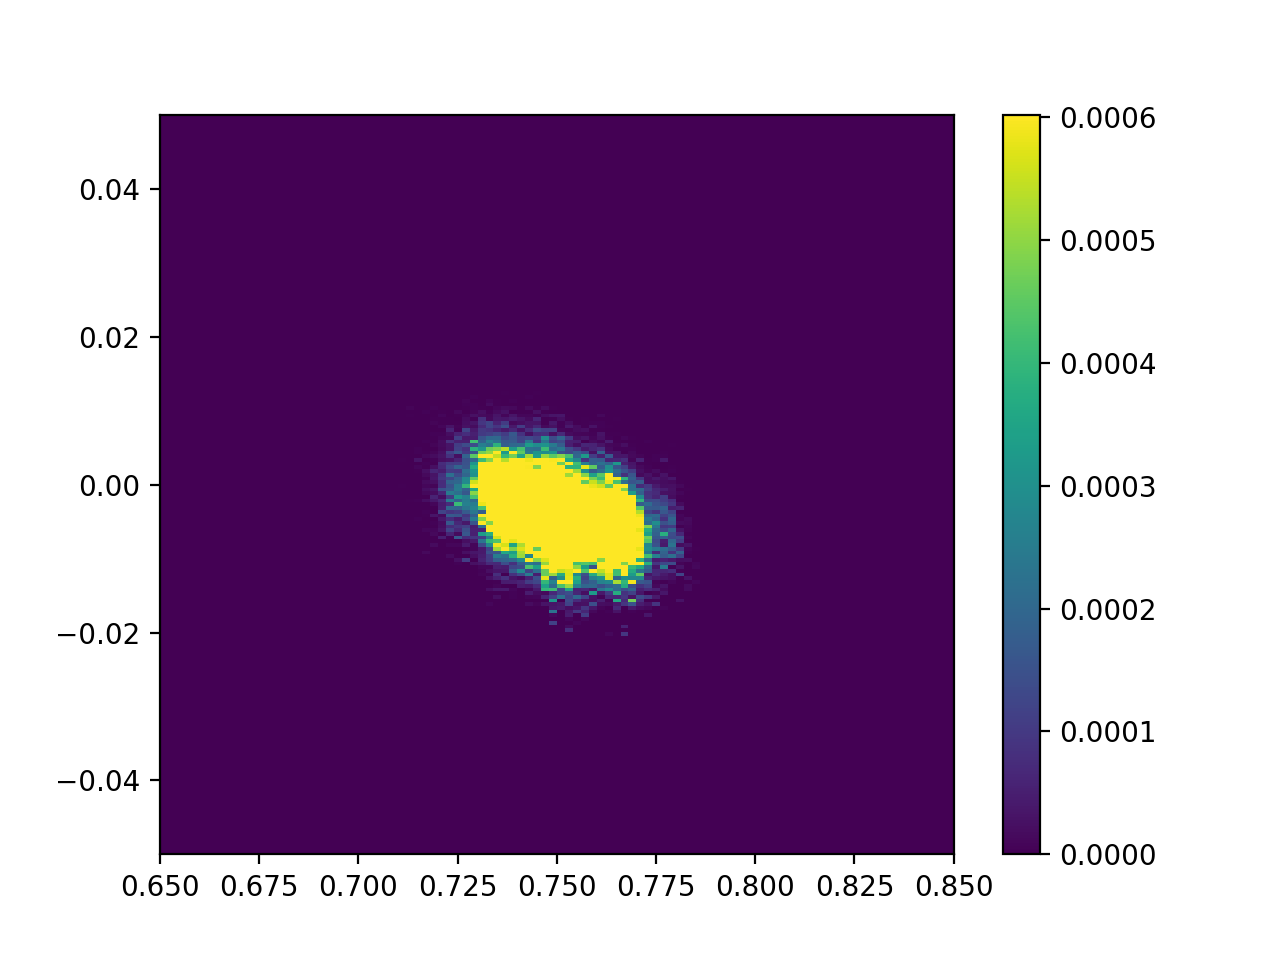

In [103]:
!ls -lh ./resolution-Ei_1.0-fluxmode_2.0-E,Q_0,0.75/res-sim/iqe.h5
iqe = hh.load('./resolution_analytical_moderator-Ei_1.0-fluxmode_2.0-E,Q_0,0.75/res-sim/iqe.h5')
iqe.I[iqe.I!=iqe.I]=0
H.plot(iqe)

<IPython.core.display.Javascript object>


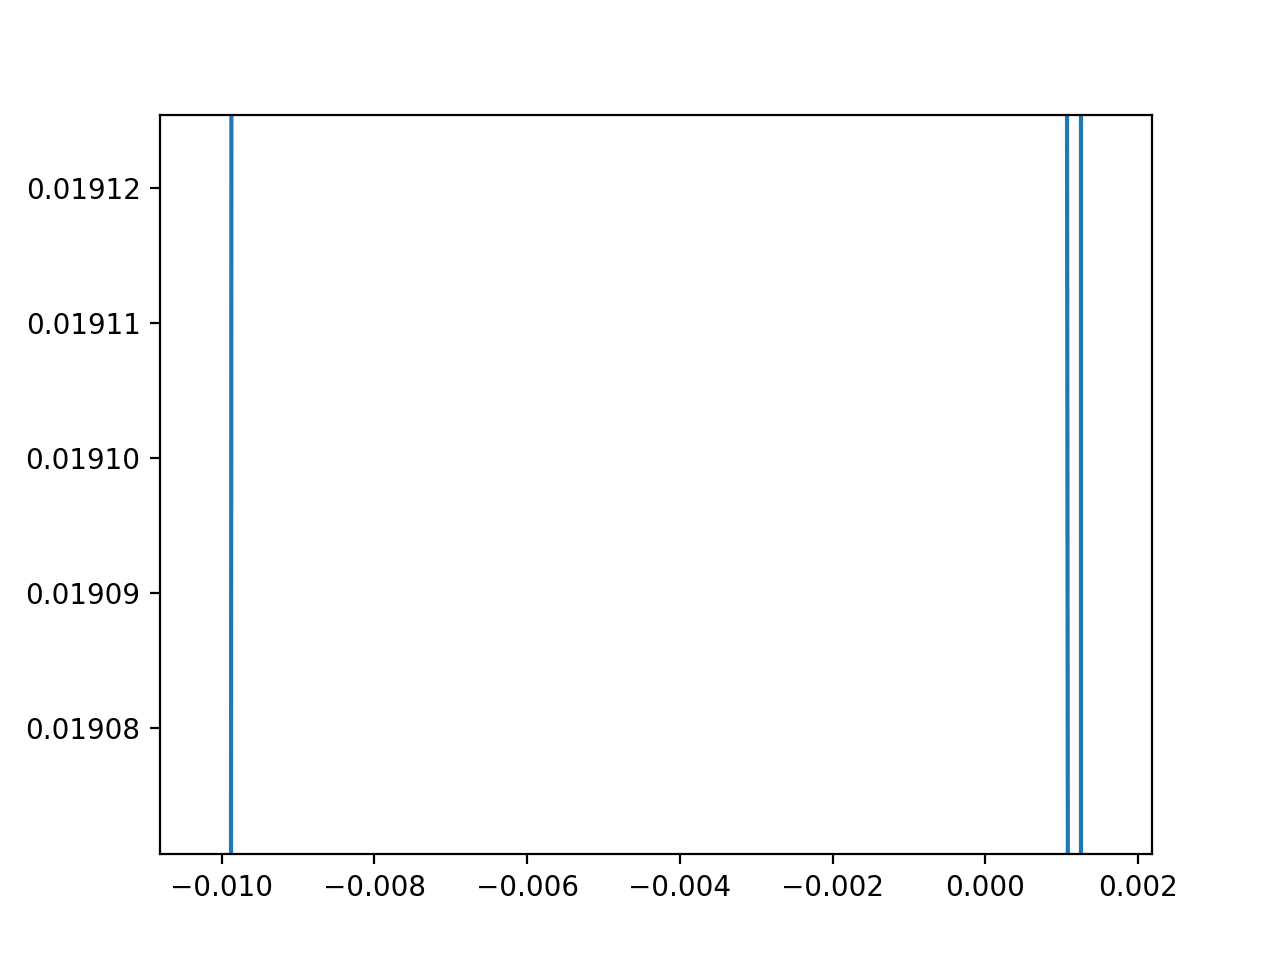

In [104]:
ie = iqe.sum('Q')
H.plot(ie)

FHWM = 0.011

In [105]:
np.var(np.ones(3))

0.0

-rw-r--r-- 1 lj7 users 74K Nov 19 22:24 ./resolution-Ei_1.0-fluxmode_2.0-E,Q_0,0.75/res-sim/iqe.h5
plot z in (0.0, 0.000680646261490435)


<IPython.core.display.Javascript object>


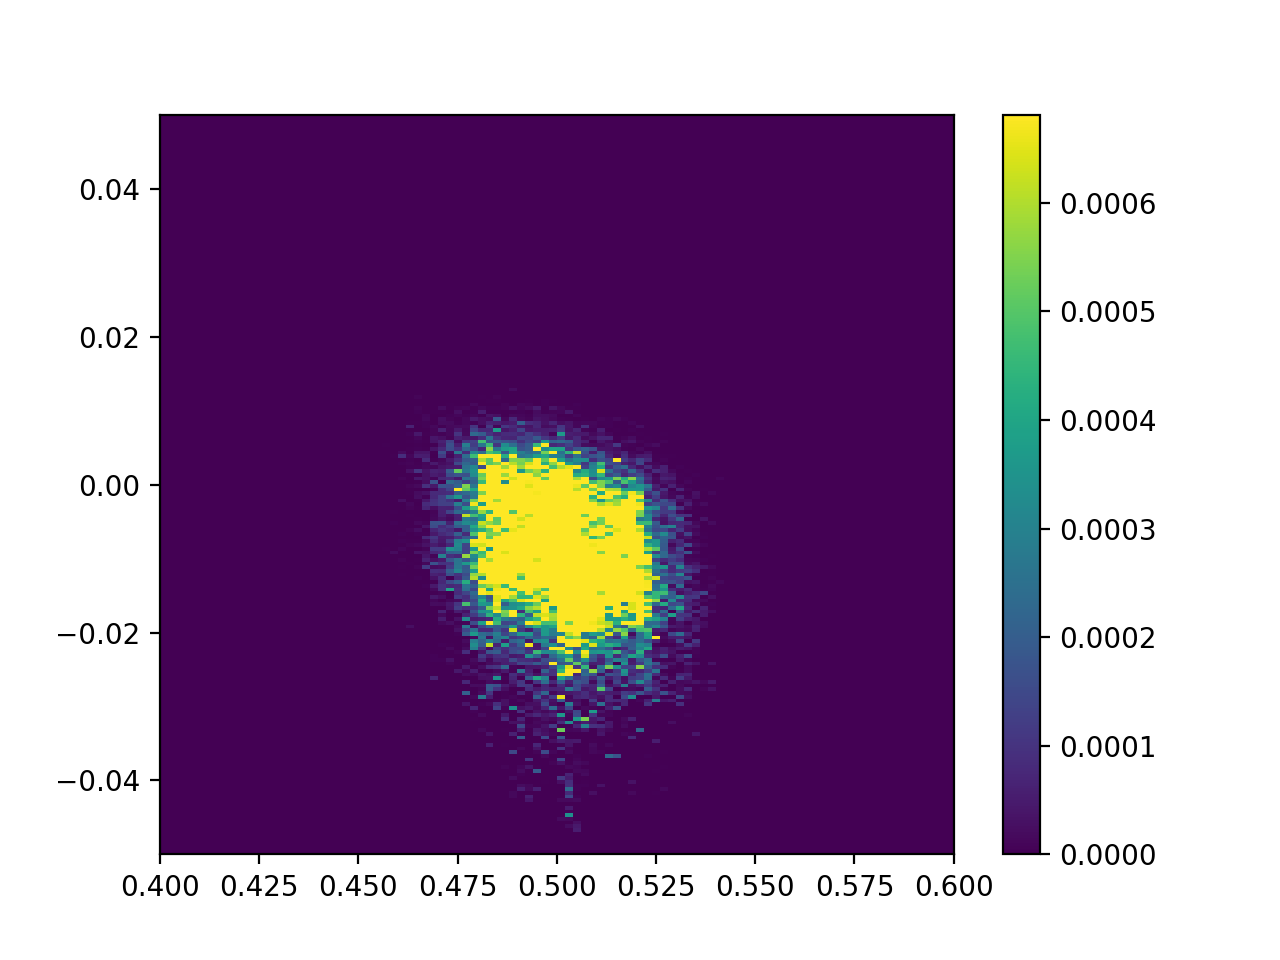

In [75]:
!ls -lh ./resolution-Ei_1.0-fluxmode_2.0-E,Q_0,0.75/res-sim/iqe.h5
iqe = hh.load('./resolution-Ei_1.0-fluxmode_2.0-E,Q_0,0.5/res-sim/iqe.h5')
iqe.I[iqe.I!=iqe.I]=0
H.plot(iqe)

In [76]:
ie = iqe.sum('Q')

<IPython.core.display.Javascript object>


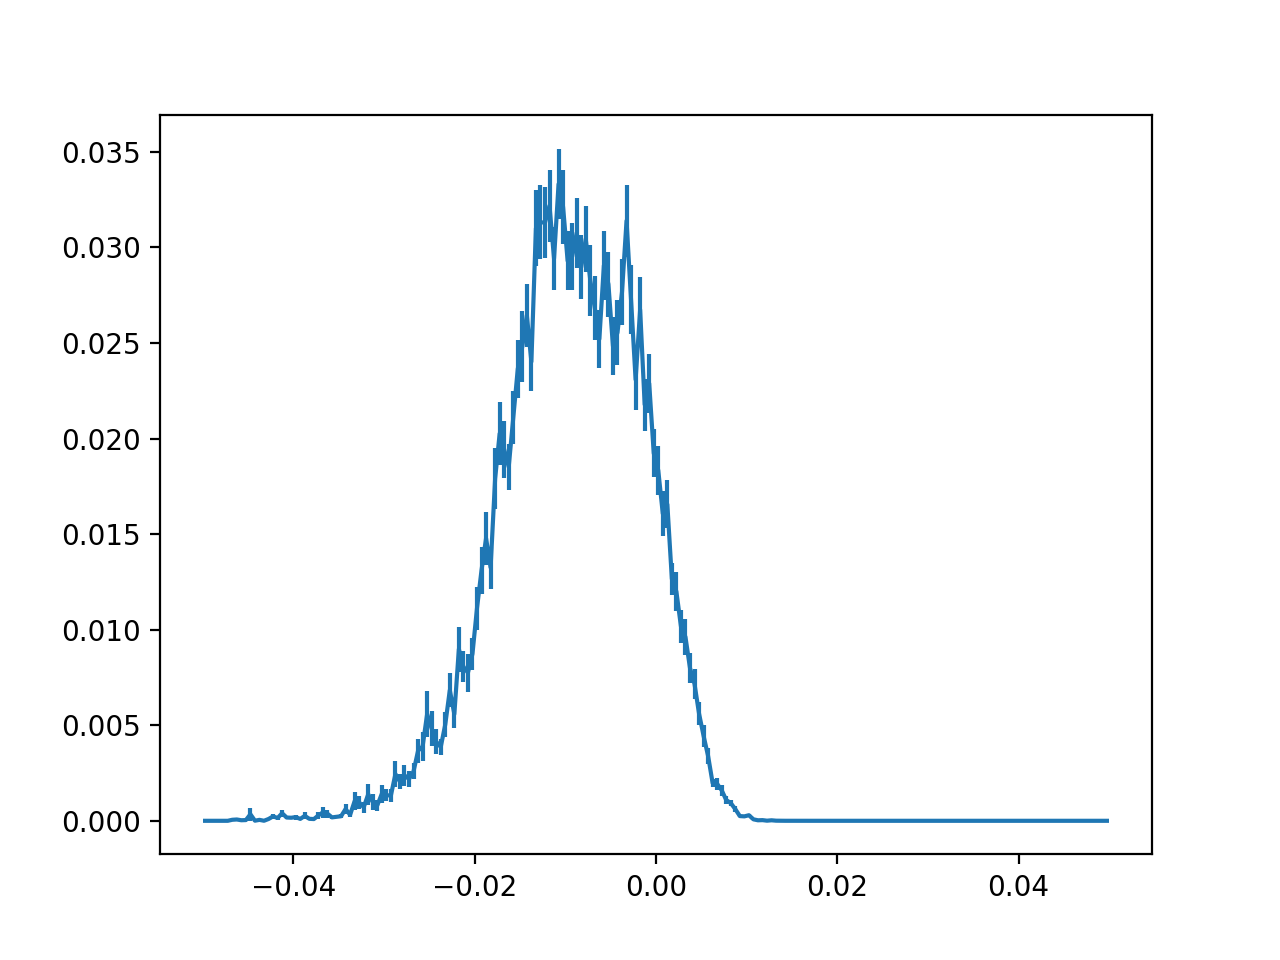

In [77]:
H.plot(ie)

In [38]:
ls -tl

total 115
drwxr-xr-x 4 lj7 users     4 Nov 19 20:24 resolution-Ei_1.0-fluxmode_2.0-E,Q_0,0.5/
-rw-r--r-- 1 lj7 users   500 Nov 19 20:15 sampleassembly.xml
drwxr-xr-x 4 lj7 users     4 Nov 17 18:43 resolution-Ei_1.0-fluxmode_2.0-E,Q_0,0.05/
drwxr-xr-x 4 lj7 users    12 Nov 17 13:21 test-beam/
drwxr-xr-x 4 lj7 users     4 Nov 17 13:18 resolution-Ei_1.0-fluxmode_2.0/
drwxr-xr-x 4 lj7 users    12 Nov 17 12:36 beam-Ei_1.0-fluxmode_2.0/
-rw-r--r-- 1 lj7 users   248 Nov 16 21:33 run-m2s.sh
-rw-r--r-- 1 lj7 users 12122 Nov 16 21:33 cncs_moderator2sample.pml


# Run all freqs

In [14]:
freqs = np.arange(60., 541., 60.)

In [15]:
%%time
for freq in freqs:
    print freq
    run(freq=freq, Ei=Ei, T0_nu=T0_nu, E=E, Q=Q, 
        dQ_axis=dQ_axis, dE_axis=dE_axis)

60.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=60.0 --ncount=1e8 --nodes=20
120.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=120.0 --ncount=1e8 --nodes=20
180.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=180.0 --ncount=1e8 --nodes=20
240.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=240.0 --ncount=1e8 --nodes=20
300.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=300.0 --ncount=1e8 --nodes=20
360.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=360.0 --ncount=1e8 --nodes=20
420.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=420.0 --ncount=1e8 --nodes=20
480.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=480.0 --ncount=1e8 --nodes=20
540.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=540.0 --ncount=1e8 --nodes=20
CPU times: user 1.16 s, sys: 267 ms, total: 1.43 s
Wall time: 3h 25min 35s


# Gather resolution and intensity data

## Resolution

In [16]:
freqs = np.arange(60., 601., 60.)

In [17]:
FWHMs = []
for freq in freqs:
    fn = 'resolution-FC_%s/out/ie-Q_%s-E_%s.h5' % (freq, Q, E)
    h = hh.load(fn)
    Is = h.I
    Es = h.E
    maxI = np.max(Is)
    upper = Es[Is > maxI/2.]
    FWHM = upper[-1] - upper[0]
    print FWHM
    FWHMs.append(FWHM)

9.95
6.8
5.75
5.55
5.2
5.0
4.6
4.4
4.0
3.6


In [ ]:
plt.figure()
plt.plot(freqs, FWHMs, '+')

The data at lower freq is large. Inspect

In [ ]:
h = hh.load('beam-FC_60.0/out/ienergy.h5')
plt.figure()
plt.plot(h.energy, h.I)

In [ ]:
h = hh.load('resolution-FC_60.0/out/ie-Q_5.0-E_0.0.h5')
plt.figure()
plt.plot(h.E, h.I)

## Intensity

In [ ]:
counts = []
for freq in freqs:
    fn = 'beam-FC_%s/out/ienergy.h5' % (freq,)
    h = hh.load(fn)
    counts.append(h.I.sum())

In [ ]:
plt.figure()
plt.plot(freqs, counts, '+')